# Neurog Internship: (Task 7 - Implementation Of Take Profit & Stop Loss (TP & SL) On The Back Testing Function In Order To Get Better Results; For Safety)

## All Libraries

In [1]:
# For Vizualization & Plotting
import matplotlib.pyplot as plt

# Other Necessary Libraries
import pandas as pd
import numpy as np
import copy

## All Declarations

In [ ]:
# Define the relative path to the CSV file
csv_filename = "BTCUSDT_1_Minute_From_2020_Till_Now.csv"

# Settig Up The Directory From The Directory Hierarchy
# Get the notebook's current directory
notebook_dir = os.path.dirname(os.path.abspath(__file__))

# Go up one level to the parent directory
parent_dir = os.path.dirname(script_dir)

# Create the full path to the output CSV file in the 'ohlc' directory within 'data'
data_dir = os.path.join(parent_dir, "data")
ohlc_dir = os.path.join(data_dir, "ohlc")
full_csv_path = os.path.join(ohlc_dir, csv_filename)

## (Function To Convert DF To Any Timeframe) - Taken From The Previous Day

In [2]:
# Functions converts the dataframe into any given time frame.
def convert_1m_to_any_timeframe(df: pd.DataFrame, timeframe: str) -> pd.DataFrame:
    """
    Convert a DataFrame of 1-minute OHLC data to any given timeframe.

    Args:
    - df (pd.DataFrame): DataFrame containing 1-minute OHLC data. 
      The DataFrame should have a datetime index & columns ['Open', 'High', 'Low', 'Close', 'Volume'].
    - timeframe (str): The desired timeframe to resample the data to (e.g., '1H' for 1 hour, '1D' for 1 day).

    Returns:
    - pd.DataFrame: Resampled DataFrame with OHLC data in the specified timeframe. The index will be renamed to
      reflect the new timeframe.

    Example:
    ```
    resampled_df = convert_1m_to_any_timeframe(ohlc_df, '1H')
    ```
    """
    # Ensure the DataFrame index is of datetime type
    df.index = pd.to_datetime(df.index)
    
    # Try resampling the data to the desired timeframe
    try:
        df_resampled = df.resample(timeframe).agg({
            'Open': 'first',  # Take the first 'Open' value in the timeframe
            'High': 'max',    # Take the maximum 'High' value in the timeframe
            'Low': 'min',     # Take the minimum 'Low' value in the timeframe
            'Close': 'last',  # Take the last 'Close' value in the timeframe
            'Volume': 'mean'  # Take the mean 'Volume' value in the timeframe
        })
    except Exception as e:
        print(f"An error occurred while resampling! Error message: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of error

    # Rename the index to reflect the new timeframe
    df_resampled.index.rename(f'Open time ({timeframe})', inplace = True)
    
    return df_resampled

## MACD Indicator Function

In [ ]:
def calculate_macd(df: pd.DataFrame, short_window: int = 12, long_window: int = 26, signal_window: int = 9) -> pd.DataFrame:
    """
    Calculate the MACD (Moving Average Convergence Divergence) for a given DataFrame.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' price data.
    - short_window (int): The window size for the short-term EMA, default is 12.
    - long_window (int): The window size for the long-term EMA, default is 26.
    - signal_window (int): The window size for the Signal line, default is 9.

    Returns:
    - pd.DataFrame: DataFrame with the MACD line and Signal line.
    """
    # Calculate the short-term and long-term EMAs
    df['EMA_12'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=long_window, adjust=False).mean()

    # Calculate the MACD line
    df['MACD'] = df['EMA_12'] - df['EMA_26']

    # Calculate the Signal line
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()

    return df

def generate_macd_signals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate trading signals based on MACD values.

    Args:
    - df (pd.DataFrame): DataFrame containing 'MACD' and 'Signal_Line' values.

    Returns:
    - pd.DataFrame: DataFrame with trading signals.
    """
    df['MACD_Signal'] = 0  # Default no signal
    df.loc[df['MACD'] > df['Signal_Line'], 'MACD_Signal'] = 1  # Buy signal
    df.loc[df['MACD'] < df['Signal_Line'], 'MACD_Signal'] = -1  # Sell signal

    return df

## Main Driver Function: Function To Generate Backtested DataFrame

In [36]:
def generate_backtest_df(data):
    """
    Generate a backtesting DataFrame based on MACD signals.

    Args:
        data (pd.DataFrame): DataFrame containing historical data with columns:
                             'Open time (4H)', 'Open', 'High', 'Low', 'Close', 'Volume', 'MACD_Signal'.
                             The DataFrame must have 'Open time (4H)' as a DateTime index.

    Returns:
        pd.DataFrame: A DataFrame containing the backtesting results with columns:
                      'Open time (4H)', 'direction', 'entry price', 'close price', 'PNL'.
    """
    # For index name
    index_name = data.index.name
    
    # Create a new dataframe for backtesting results
    backtest_df = pd.DataFrame(columns=[index_name, 'direction', 'entry price', 'close price', 'action'])
    
    # Initialize variables for tracking positions
    current_signal = None
    counter = 0
    
    # 5% and 3% values for price saved and the current trade price
    five_perc_entry = 0
    three_perc_entry = 0
    curr_trade_price = None
    
    # Bool flag for start
    start = False
    
    # Direction for the trade and the action taken (hit)
    direction = None
    action = None
    
    # Initialize percentages for loss and profit
    tp = 5
    sl = 3

    # Iterate through rows of the original dataframe
    for index, row in data.iterrows():
        signal = row['MACD_Signal']
        entry_price = row['Open']
        
        # skip rows where signal is 0
        if signal == 0 and not start:
            continue
            
        if direction == 'long':
            if entry_price - curr_trade_price >= five_perc_entry or entry_price - curr_trade_price <= -three_perc_entry:
                # Add new row to the data frame
                direction = 'long' if signal == 1 else 'short'
                entry_price = backtest_df.iloc[counter - 1]['entry price']
                close_price = row['Open']
                action = 'tp' if entry_price - curr_trade_price > five_perc_entry else 'sl'
                backtest_df.loc[counter, [index_name, 'direction', 'entry price', 'close price', 'action']] = [index, direction, entry_price, close_price, action]

                # Update the current signal
                current_signal = signal
                counter += 1

                # Add another row to the data frame with same timeframe, but close price of last row
                # as entry price of the new row (New trade has begun)
                backtest_df.loc[counter, [index_name, 'direction', 'entry price', 'close price', 'action']] = [index, direction, close_price, 0, None]
                counter += 1

                # Storing current entry price for trade
                curr_trade_price = entry_price

                # Storing price according to percentage
                five_perc_entry = close_price * (tp / 100)
                three_perc_entry = close_price * (sl / 100)
                
        if direction == 'short':
            if entry_price - curr_trade_price >= three_perc_entry or entry_price - curr_trade_price <= -five_perc_entry:
                # Add new row to the data frame
                direction = 'long' if signal == 1 else 'short'
                entry_price = backtest_df.iloc[counter - 1]['entry price']
                close_price = row['Open']
                action = 'sl' if entry_price - curr_trade_price > three_perc_entry else 'tp'
                backtest_df.loc[counter, [index_name, 'direction', 'entry price', 'close price', 'action']] = [index, direction, entry_price, close_price, action]

                # Update the current signal
                current_signal = signal
                counter += 1

                # Add another row to the data frame with same timeframe, but close price of last row
                # as entry price of the new row (New trade has begun)
                backtest_df.loc[counter, [index_name, 'direction', 'entry price', 'close price', 'action']] = [index, direction, close_price, 0, None]
                counter += 1

                # Storing current entry price for trade
                curr_trade_price = entry_price

                # Storing price according to percentage
                five_perc_entry = close_price * (tp / 100)
                three_perc_entry = close_price * (sl / 100)
                
        if current_signal is None:
            # First entry
            direction = 'long' if signal == 1 else 'short'
            entry_price = row['Open']  # Initial entry price
            backtest_df.loc[counter, [index_name, 'direction', 'entry price', 'close price', 'action']] = [index, direction, entry_price, 0, None]
            
            # Update the current signal
            current_signal = signal
            counter += 1
            
            # Storing current entry price for trade
            curr_trade_price = entry_price
            
            # Storing price according to percentage
            five_perc_entry = entry_price * (tp / 100)  # Profit
            three_perc_entry = entry_price * (sl / 100) # Loss
            
            # Trade is started
            start = True
            
        elif (int(signal) + int(current_signal)) == 0:
            # Signal change detected
            # Add new row to the data frame
            direction = 'long' if signal == 1 else 'short'
            entry_price = backtest_df.iloc[counter - 1]['entry price']
            close_price = row['Open']
            action = 'direction'
            backtest_df.loc[counter, [index_name, 'direction', 'entry price', 'close price', 'action']] = [index, direction, entry_price, close_price, action]
            
            # Update the current signal
            current_signal = signal
            counter += 1
            
            # Add another row to the data frame with same timeframe, but close price of last row
            # as entry price of the new row (New trade has begun)
            backtest_df.loc[counter, [index_name, 'direction', 'entry price', 'close price', 'action']] = [index, direction, close_price, 0, None]
            counter += 1
            
            # Storing current entry price for trade
            curr_trade_price = entry_price
            
            # Storing price according to percentage
            five_perc_entry = close_price * (tp / 100)
            three_perc_entry = close_price * (sl / 100)

    # Store the trade entry and exit prices along with direction for each trade pair
    entry_prices = backtest_df['entry price'][1::2].values
    close_prices = backtest_df['close price'][1::2].values
    directions = backtest_df['direction'][::2].values[:-1]

    # Calculate PNL using vectorized operations
    pnl = np.where(directions == 'long',
                   ((close_prices - entry_prices) / entry_prices) * 100,
                   ((entry_prices - close_prices) / entry_prices) * 100)

    # Insert the PNL values back into the DataFrame
    backtest_df.loc[1::2, 'PNL'] = pnl

    return backtest_df

## Main Driver Function Another Way: Function To Generate Backtested DataFrame

In [37]:
def generate_backtest_df_2(data):
    """
    Generate a backtesting DataFrame based on MACD signals.

    Args:
        data (pd.DataFrame): DataFrame containing historical data with columns:
                             'Open time (4H)', 'Open', 'High', 'Low', 'Close', 'Volume', 'MACD_Signal'.
                             The DataFrame must have 'Open time (4H)' as a DateTime index.

    Returns:
        pd.DataFrame: A DataFrame containing the backtesting results with columns:
                      'Open time (4H)', 'direction', 'entry price', 'close price', 'PNL', 'action'.
    """
    # For index name
    index_name = data.index.name
    
    # Define the percentage thresholds for profit and loss
    tp = 5 / 100
    sl = 3 / 100
    
    # Initialize lists to collect backtest results
    timestamps = []
    directions = []
    entry_prices = []
    close_prices = []
    actions = []
    
    # Initialize variables for tracking positions
    current_signal = None
    curr_trade_price = None
    direction = None
    five_perc_entry = None
    three_perc_entry = None
    
    # Iterate through rows of the original dataframe
    for index, row in data.iterrows():
        signal = row['MACD_Signal']
        entry_price = row['Open']
        
        if signal == 0 and current_signal is None:
            continue

        if current_signal is None:
            # First entry
            direction = 'long' if signal == 1 else 'short'
            current_signal = signal
            curr_trade_price = entry_price
            five_perc_entry = curr_trade_price * tp
            three_perc_entry = curr_trade_price * sl
            timestamps.append(index)
            directions.append(direction)
            entry_prices.append(curr_trade_price)
            close_prices.append(0)
            actions.append('direction')
            continue

        if (direction == 'long' and (entry_price - curr_trade_price >= five_perc_entry or curr_trade_price - entry_price >= three_perc_entry)) or \
           (direction == 'short' and (curr_trade_price - entry_price >= five_perc_entry or entry_price - curr_trade_price >= three_perc_entry)) or \
           (int(signal) + int(current_signal)) == 0:
            
            # Determine the action
            if (direction == 'long' and entry_price - curr_trade_price >= five_perc_entry) or \
               (direction == 'short' and curr_trade_price - entry_price >= five_perc_entry):
                action = 'tp'
            elif (direction == 'long' and curr_trade_price - entry_price >= three_perc_entry) or \
                 (direction == 'short' and entry_price - curr_trade_price >= three_perc_entry):
                action = 'sl'
            else:
                action = 'direction'
            
            # Close the previous trade
            timestamps.append(index)
            directions.append(direction)
            entry_prices.append(curr_trade_price)
            close_prices.append(entry_price)
            actions.append(action)
            
            # Start a new trade
            direction = 'long' if signal == 1 else 'short'
            current_signal = signal
            curr_trade_price = entry_price
            five_perc_entry = curr_trade_price * tp
            three_perc_entry = curr_trade_price * sl
            timestamps.append(index)
            directions.append(direction)
            entry_prices.append(curr_trade_price)
            close_prices.append(0)
            actions.append('direction')
    
    # Create the backtest DataFrame
    backtest_df = pd.DataFrame({
        index_name: timestamps,
        'direction': directions,
        'entry price': entry_prices,
        'close price': close_prices,
        'action': actions
    })

    # Calculate PNL
    backtest_df['PNL'] = np.where(
        backtest_df['direction'] == 'long',
        ((backtest_df['close price'] - backtest_df['entry price']) / backtest_df['entry price']) * 100,
        ((backtest_df['entry price'] - backtest_df['close price']) / backtest_df['entry price']) * 100
    )
    
    # Replace -100 or 100 with NaN in 'PNL' column
    backtest_df['PNL'] = backtest_df['PNL'].replace({-100: 0.0, 100: 0.0})

    return backtest_df

## Main

### Reading The Previously Saved Data For BTCUSDT

In [3]:
BTCUSDT_Filtered_data_1M = pd.read_csv(full_csv_path)
BTCUSDT_Filtered_data_1M.set_index('Open time (1M)', inplace = True)

# Convert the index to datetime format
BTCUSDT_Filtered_data_1M.index = pd.to_datetime(BTCUSDT_Filtered_data_1M.index)

In [4]:
BTCUSDT_Filtered_data_1M

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
Open time (1M),,,,,,,,,
2020-01-01 00:00:00,7169.71,7169.71,7165.44,7167.83,3509.860,2.515594e+07,139.0,1025.400,7.348382e+06
2020-01-01 00:01:00,7167.83,7168.28,7158.66,7159.95,3821.170,2.737640e+07,155.0,1571.990,1.126101e+07
2020-01-01 00:02:00,7161.03,7165.40,7161.03,7162.46,3041.710,2.178758e+07,122.0,1439.790,1.031332e+07
2020-01-01 00:03:00,7161.74,7164.27,7160.30,7161.03,3682.650,2.637680e+07,147.0,1557.630,1.115700e+07
2020-01-01 00:04:00,7161.03,7164.25,7160.15,7160.15,2936.690,2.103310e+07,113.0,1407.430,1.007968e+07
...,...,...,...,...,...,...,...,...,...
2024-07-05 10:41:00,55700.00,55700.00,55397.30,55500.00,1.283,7.120373e+04,23.0,0.010,5.555000e+02
2024-07-05 10:42:00,55500.00,55562.40,54959.50,55500.00,4.314,2.385602e+05,45.0,2.111,1.170360e+05
2024-07-05 10:43:00,55500.00,55500.00,54760.00,54923.90,8.064,4.438382e+05,48.0,1.990,1.101392e+05


### Display Graph For Close Price (1 Minute Interval)

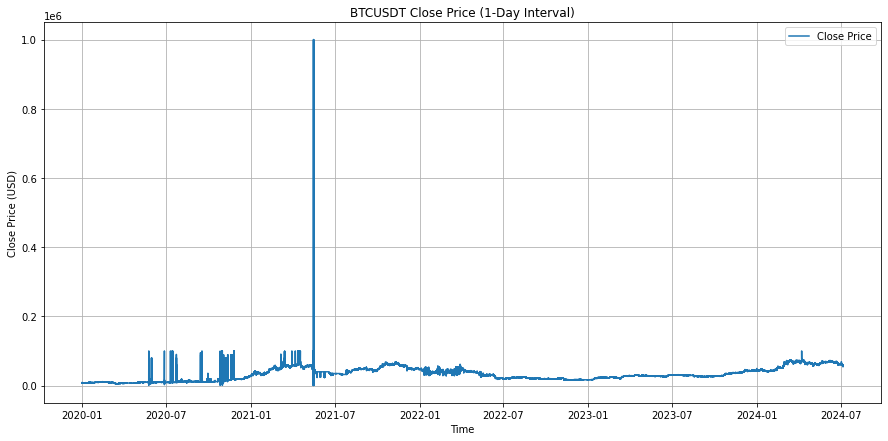

In [5]:
# Plot the 'Close' price over time
plt.figure(figsize=(15, 7))
plt.plot(BTCUSDT_Filtered_data_1M['Close'], label='Close Price')
plt.title('BTCUSDT Close Price (1-Day Interval)')
plt.xlabel('Time')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

## Now, Enough Plotting! On The Task!

## Generate Different Timeframe

### Converting 1 Minute Interval Data to 4 Hour Interval Data

In [6]:
BTCUSDT_Filtered_data_4H = convert_1m_to_any_timeframe(copy.deepcopy(BTCUSDT_Filtered_data_1M), '4H')
BTCUSDT_Filtered_data_4H

,Open,High,Low,Close,Volume
Open time (4H),,,,,
2020-01-01 00:00:00,7169.71,7207.23,7156.65,7202.48,3428.062092
2020-01-01 04:00:00,7202.48,9592.00,6871.45,7241.63,285722.475587
2020-01-01 08:00:00,7241.63,7243.46,7215.94,7223.72,3629.004242
2020-01-01 12:00:00,7223.71,7233.33,7178.00,7201.02,3491.032767
2020-01-01 16:00:00,7201.56,7236.58,7187.86,7220.85,3125.298729
...,...,...,...,...,...
2024-07-04 16:00:00,57890.00,58600.00,56666.00,57628.80,50.266283
2024-07-04 20:00:00,57628.80,59111.00,57438.20,58768.00,7.108233
2024-07-05 00:00:00,58650.70,59706.50,57000.10,58359.00,11.704692


## Performing Back Testing

### Using Signals Generated From MACD On 1 Year Data Of 4-Hour Time Interval

### Extracting 1 Year Data

In [10]:
# Fetch 1 Year Data
BTCUSDT_Filtered_data_4H_Prev_1_Year = BTCUSDT_Filtered_data_4H.loc['2023-07-02' : '2024-07-02']
BTCUSDT_Filtered_data_4H_Prev_1_Year

,Open,High,Low,Close,Volume
Open time (4H),,,,,
2023-07-02 00:00:00,30598.0,30700.0,30418.0,30679.9,66.690854
2023-07-02 04:00:00,30679.9,30700.0,30300.5,30432.1,63.147079
2023-07-02 08:00:00,30432.1,30637.0,30160.1,30379.4,66.269358
2023-07-02 12:00:00,30379.4,30636.0,30251.0,30441.7,69.949029
2023-07-02 16:00:00,30379.3,30499.0,30185.1,30406.9,71.054587
...,...,...,...,...,...
2024-07-02 04:00:00,64073.8,64160.9,63010.0,63100.3,4.206158
2024-07-02 08:00:00,63343.3,63999.9,63030.6,63051.1,4.505912
2024-07-02 12:00:00,63278.6,63712.6,62260.0,62826.0,7.381213


### Generating Signals Using MACD Indicator Function

In [11]:
# Calculate MACD for the 4-Hour data
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_4H_Prev_1_Year))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd = BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd[[
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'MACD_Signal'
]]
BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd

,Open,High,Low,Close,Volume,MACD_Signal
Open time (4H),,,,,,
2023-07-02 00:00:00,30598.0,30700.0,30418.0,30679.9,66.690854,0
2023-07-02 04:00:00,30679.9,30700.0,30300.5,30432.1,63.147079,-1
2023-07-02 08:00:00,30432.1,30637.0,30160.1,30379.4,66.269358,-1
2023-07-02 12:00:00,30379.4,30636.0,30251.0,30441.7,69.949029,-1
2023-07-02 16:00:00,30379.3,30499.0,30185.1,30406.9,71.054587,-1
...,...,...,...,...,...,...
2024-07-02 04:00:00,64073.8,64160.9,63010.0,63100.3,4.206158,1
2024-07-02 08:00:00,63343.3,63999.9,63030.6,63051.1,4.505912,1
2024-07-02 12:00:00,63278.6,63712.6,62260.0,62826.0,7.381213,1


### Applying The Backtesting Algorithm

In [38]:
backtest_df_og_func = generate_backtest_df(BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd)
backtest_df_og_func

,Open time (4H),direction,entry price,close price,action,PNL
0,2023-07-02 04:00:00,short,30679.9,0,None,NaN
1,2023-07-03 20:00:00,long,30679.9,30490.0,direction,0.618972
2,2023-07-03 20:00:00,long,30490.0,0,None,NaN
3,2023-07-05 12:00:00,short,30490.0,30820.0,direction,1.082322
4,2023-07-05 12:00:00,short,30820.0,0,None,NaN
...,...,...,...,...,...,...
596,2024-06-27 04:00:00,short,61786.6,0,None,NaN
597,2024-06-27 16:00:00,long,61786.6,61415.4,direction,0.600778
598,2024-06-27 16:00:00,long,61415.4,0,None,NaN
599,2024-07-01 20:00:00,long,61415.4,65217.4,sl,6.19063


### Displaying the Cumulative Profit & Loss (PNL) 

In [39]:
backtest_df_og_func['PNL'].sum()

301.1126158774166

### Applying The Second Backtesting Algorithm

In [ ]:
# temp_4 = generate_backtest_df(BTCUSDT_Filtered_data_1M_Prev_1_Year_with_macd)
backtest_df_2nd_func = generate_backtest_df_2(BTCUSDT_Filtered_data_4H_Prev_1_Year_with_macd)
backtest_df_2nd_func

### Displaying the Cumulative Profit & Loss (PNL) 

In [25]:
temp_2['PNL'].sum()

298.34261450517187

### Using Signals Generated From MACD On 2 Week Data Of 1-Minute Time Interval

### Extracting 2 Week Data

In [41]:
# Fetch 1 Year Data
BTCUSDT_Filtered_data_1M_Prev_2_week = BTCUSDT_Filtered_data_1M.loc['2023-10-08' : '2023-10-22']
# Calculate MACD for the 4-Hour data
BTCUSDT_Filtered_data_1M_Prev_2_week_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_1M_Prev_2_week))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_1M_Prev_2_week_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_1M_Prev_2_week_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_1M_Prev_2_week_with_macd = BTCUSDT_Filtered_data_1M_Prev_2_week_with_macd[[
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'MACD_Signal'
]]
BTCUSDT_Filtered_data_1M_Prev_2_week_with_macd

,Open,High,Low,Close,Volume,MACD_Signal
Open time (1M),,,,,,
2023-10-08 00:00:00,27889.2,27892.7,27880.1,27892.7,86.216,0
2023-10-08 00:01:00,27895.4,27895.5,27880.1,27887.4,66.013,-1
2023-10-08 00:02:00,27880.1,27894.1,27880.1,27882.5,177.396,-1
2023-10-08 00:03:00,27890.8,27890.8,27880.1,27882.9,128.985,-1
2023-10-08 00:04:00,27882.9,27882.9,27880.1,27882.9,32.116,-1
...,...,...,...,...,...,...
2023-10-22 23:55:00,29895.0,29895.2,29889.8,29895.2,51.466,-1
2023-10-22 23:56:00,29895.2,29895.2,29888.9,29888.9,103.877,-1
2023-10-22 23:57:00,29895.2,29895.2,29884.1,29895.2,56.315,-1


### Applying The Backtesting Algorithm

In [43]:
# temp_4 = generate_backtest_df(BTCUSDT_Filtered_data_1M_Prev_1_Year_with_macd)
backtest_df_og_func_2w1m = generate_backtest_df(BTCUSDT_Filtered_data_1M_Prev_2_week_with_macd)
backtest_df_og_func_2w1m

,Open time (1M),direction,entry price,close price,action,PNL
0,2023-10-08 00:01:00,short,27895.4,0,None,NaN
1,2023-10-08 00:12:00,long,27895.4,27880.2,direction,0.054489
2,2023-10-08 00:12:00,long,27880.2,0,None,NaN
3,2023-10-08 00:23:00,short,27880.2,27887.2,direction,0.025107
4,2023-10-08 00:23:00,short,27887.2,0,None,NaN
...,...,...,...,...,...,...
6664,2023-10-22 23:29:00,short,29861.2,0,None,NaN
6665,2023-10-22 23:32:00,long,29861.2,29774.9,direction,0.289004
6666,2023-10-22 23:32:00,long,29774.9,0,None,NaN
6667,2023-10-22 23:51:00,short,29774.9,29894.0,direction,0.400001


### Displaying The Cumulative Profit & Loss (PNL)

In [44]:
backtest_df_og_func_2w1m['PNL'].sum()

289.2554751674793

### Applying The Second Backtesting Algorithm

In [46]:
backtest_df_2nd_func_2w1m = generate_backtest_df_2(BTCUSDT_Filtered_data_1M_Prev_2_week_with_macd)
backtest_df_2nd_func_2w1m

,Open time (1M),direction,entry price,close price,action,PNL
0,2023-10-08 00:01:00,short,27895.4,0.0,direction,0.000000
1,2023-10-08 00:12:00,short,27895.4,27880.2,direction,0.054489
2,2023-10-08 00:12:00,long,27880.2,0.0,direction,0.000000
3,2023-10-08 00:23:00,long,27880.2,27887.2,direction,0.025107
4,2023-10-08 00:23:00,short,27887.2,0.0,direction,0.000000
...,...,...,...,...,...,...
6658,2023-10-22 23:29:00,short,29861.2,0.0,direction,0.000000
6659,2023-10-22 23:32:00,short,29861.2,29774.9,direction,0.289004
6660,2023-10-22 23:32:00,long,29774.9,0.0,direction,0.000000
6661,2023-10-22 23:51:00,long,29774.9,29894.0,direction,0.400001


### Displaying The Cumulative Profit & Loss (PNL)

In [47]:
temp_4['PNL'].sum()

298.34261450517187

# ***More Later!***